# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPdfdfdRjJXXXXX' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcdfdfdjD3dKBe682Yt2MOiNv6bXXXX' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24dfdfdfvBgwXKyPi5bXXXX' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEdfdfdfYDS9VfIzOboQoXXXX'<br />

## Modulo para autenticação no twitter

In [1]:
!ls *.txt

dados.txt  stopwords-portugues.txt  tokens.txt	tokes.txt


In [ ]:
#!pip install twitter
#!pip install pymongo

In [2]:
!cat tokens.txt

DcPtlOYZ07jilc3PgYJLUPRjJ
bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b
2904474861-qPmMjcwisBQWR1cMILoXevC8QeKS3Go3PzN5lBq
h0iaWqpk7YqsP9MAk5mU472ZOsFOtunfL76fwhEY3x9PA

## Leitura das chaves de acesso

In [3]:
def ler_tokens_acesso():
    filename = 'tokens.txt'
    with open(filename) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    return content[0], content[1], content[2], content[3]

#CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
#print(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# Twitter

In [4]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    #CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUdfdfdfJ'
    #CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOdfdf'
    
    #OAUTH_TOKEN = '2904474861-hJHuW0Q1TGSUjOFvlgqU4ZFYvPCDO214aILxR5L'
   # OAUTH_TOKEN_SECRET = 'aBCJrbhXVEBgZ7gKo9yCNUMjlierefMkY43rZEvXK9BFI'
    
    CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [5]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [6]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [7]:
%%time

q = 'covid'
q = 'omicron'
result = twitter_search(twitter_api, q, max_results=5000)
type(result)

CPU times: user 295 ms, sys: 71.2 ms, total: 366 ms
Wall time: 29.7 s


list

In [20]:
result[1]

{'created_at': 'Tue Dec 14 23:34:07 +0000 2021',
 'id': 1470899936590024705,
 'id_str': '1470899936590024705',
 'text': 'RT @MarcoSanchezGue: Para evitar contagios con #Omicron es muy importante enfocarse en promover  el uso obligado y correcto del 😷, ventilar…',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'Omicron', 'indices': [47, 55]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'MarcoSanchezGue',
    'name': 'Marco Sanchez-Guerra',
    'id': 2343806622,
    'id_str': '2343806622',
    'indices': [3, 19]}],
  'urls': []},
 'metadata': {'iso_language_code': 'es', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1268234546941702144,
  'id_str': '1268234546941702144',
  'name': 'Inés Hernández',
  'screen_name':

In [9]:
len(result)

1100

In [ ]:
#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(result, 'Tokyo2020', q)

In [17]:
%%time

q = 'omicron'
twitter_api = oauth_login()
results = []
for i in range(3):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
print("Numero de tweets capturados: ", len(results))

results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(results, 'tweets', q)

capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
Numero de tweets capturados:  3300
CPU times: user 1.56 s, sys: 146 ms, total: 1.71 s
Wall time: 1min 16s


In [19]:
results[0] 

{'created_at': 'Tue Dec 14 23:34:26 +0000 2021',
 'id': 1470900015170297867,
 'id_str': '1470900015170297867',
 'text': 'RT @statsjamie: 🚨🚨 Denmark - #Omicron 2,471 cases identified as of 12 December.\n\n◼️ 13.5% in unvaccinated\n◼️ 2.4% One dose only\n◼️ 74.6% Tw…',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'Omicron', 'indices': [29, 37]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'statsjamie',
    'name': 'Jamie Jenkins',
    'id': 101447362,
    'id_str': '101447362',
    'indices': [3, 14]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1005249848,
  'id_str': '1005249848',
  'name': 'Simon',
  'screen_name': 'GargoyleSpanker',
  'location': '

In [12]:
results[2]['created_at']

'Tue Dec 14 10:37:50 +0000 2021'

In [13]:
results[2]['metadata']['iso_language_code']

'th'

In [14]:
len(results)

3300

## imprimindo tweets

In [15]:
#result = results
i = 0
for tweet in results:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

RT @PoliticsForAlI: 🚨🚨🚨 | BREAKING: The Sunday Times’ data expert Tom Calver: “The theory that Omicron causes milder symptoms is becoming v…
RT @wouterkeller: Reuters: 'Ca 80% vd eerste 43 OMICRON besmettingen in de USA was gevaccineerd.'  

https://t.co/GSexnTF3mC
RT @manopsi: คนที่เคยกล่าวว่า Omicron เป็นแล้วไม่รุนแรง ไม่มีใครเสียชีวิต ต้องอ่านข่าวนี้หน่อยนะครับ 🙄

https://t.co/5kdx4BbC0o
RT @PoliticsForAlI: 🚨🚨🚨🚨 | BREAKING: The First real world analysis of Omicron from S Africa shows it is 29% MILDER than the initial covid v…
RT @PoliticsForAlI: 🚨🚨🚨🚨 | BREAKING: The First real world analysis of Omicron from S Africa shows it is 29% MILDER than the initial covid v…
RT @SkyNews: BREAKING: A major real-world study on the potential impact of Omicron has shown two doses of Pfizer-Biontech vaccines gives 70…
RT @PoliticsForAlI: 🚨🚨🚨🚨 | BREAKING: The First real world analysis of Omicron from S Africa shows it is 29% MILDER than the initial covid v…
RT @GarySidley: Of the 1700 people who hav

## Nuvem de Palavras - tweet

### Stopwords

In [18]:
# instalando o módulo de stopwords
#!pip install stop-words
results = result

In [19]:
from stop_words import get_stop_words

stop_words_portugues = get_stop_words('pt')
print(stop_words_portugues)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

In [20]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')
#stop_words
stop_words_portugues = get_stop_words('pt')
#stop_words_portugues
stop_words = stop_words_english + stop_words_portugues
print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [ ]:
#!pip install wordcloud

In [21]:
type(result)

list

In [22]:
result[5]

{'created_at': 'Thu Sep 23 22:38:57 +0000 2021',
 'id': 1441170249181589513,
 'id_str': '1441170249181589513',
 'text': 'RT @RealCandaceO: Did you know you need a vaccine passport to enter all businesses in NYC but you do not need one to enter the subway. \n\nSo…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'RealCandaceO',
    'name': 'Candace Owens',
    'id': 878247600096509952,
    'id_str': '878247600096509952',
    'indices': [3, 16]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1303780092510834688,
  'id_str': '1303780092510834688',
  'name': 'possibly Antonio’s girlfriend',
  'screen_name': 'alyargx',
  'lo

111985


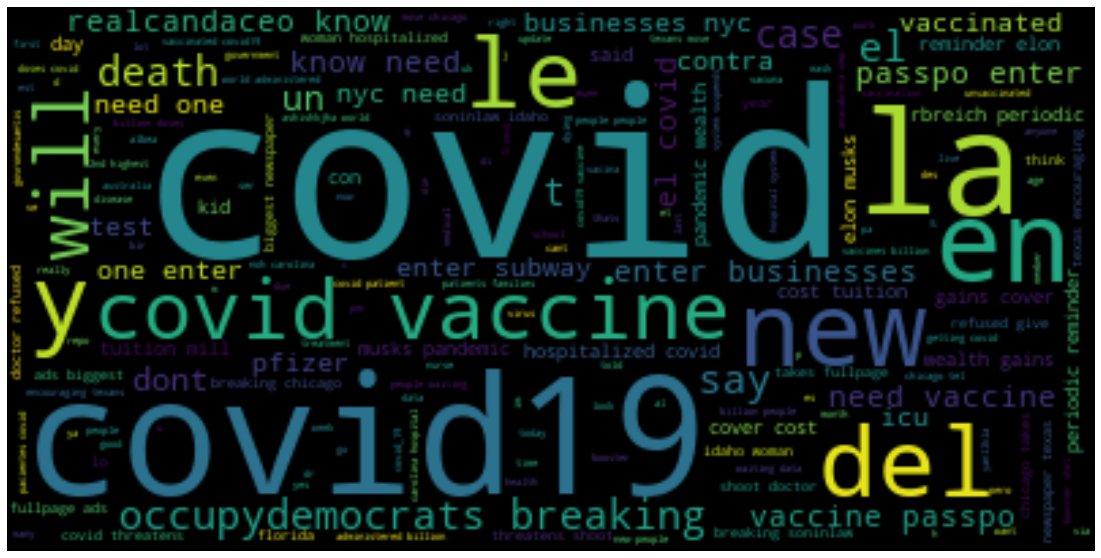

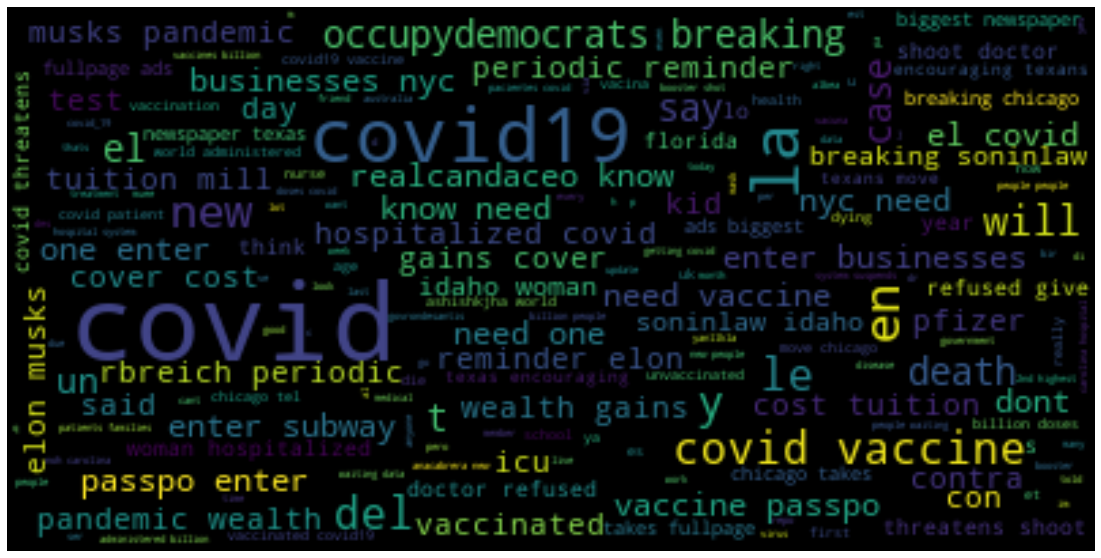

In [23]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text'] + ' '
        
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")
stext = stext.replace("tco","")
stext = stext.replace("rt","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [24]:
words = stext.split()

In [25]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

covid
covid19
la
people
el
vaccine
en
y
need
one
los
new
del
get
vaccinated
enter
breaking:
now
hospital
patients
will
occupydemocrats:
chicago
vaccines
las
know
us
"
un
le
today
con
billion
just
icu
doctor
contra
pandemic
t
day


In [26]:
for i in range(15):
    print (c.popitem())

('9995%', 1)
('lives"', 1)
('hands', 1)
('filthy', 1)
('"lay', 1)
('episode', 1)
('justin_ha:', 1)
('$12', 1)
('$20', 1)
('leftyvonne:', 1)
('mcadelemiz', 1)
('ile', 1)
('musibet', 1)
('bulamadk', 1)
('bile', 1)


## colocando as palavras e suas frequencias do twitter num dataframe

In [27]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

,Word,Frequency
0,covid,515
1,covid19,191
2,la,109
3,people,87
4,el,86
5,vaccine,80
6,en,64
7,y,59
8,need,49
9,one,47


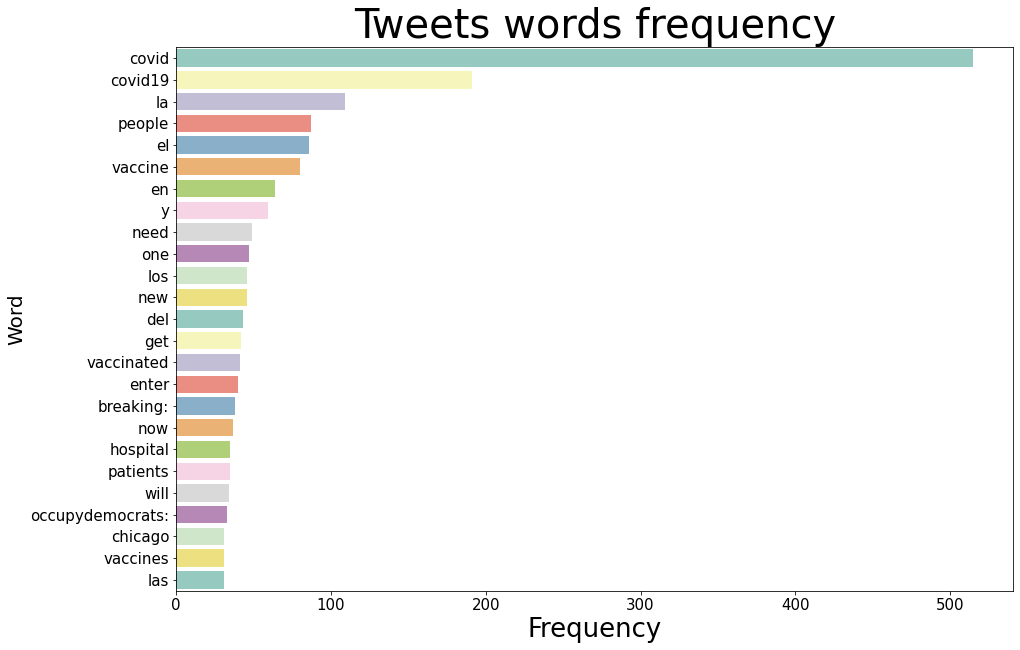

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [29]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

4
{'Canada', 'Colombia', 'Argentina', 'United States'}


In [30]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

550

In [31]:
for i in range(15):
    print(location.pop())


🇨🇭🇸🇪
The Dragon’s Lair at East Rock
SC
Paris, France
Polska
Massachusetts, USA
Pittston 
Ukraine
I'm gonna beep and boop
United States
Knoxville, TN
FL/-International
St Joseph, MO
Seattle, WA


## contar a ocorrencia de cada cidade

In [32]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [33]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

,city,frequency
0,"Columbus, OH",1
1,"Redlands, CA",1
2,"Glasgow, Scotland",1
3,The Grow House,1
4,Porto Alegre - RS,1
5,Detrás de tu conciencia,1
6,"St Petersburg, FL",1
7,"Canton, GA",1
8,"Hartlepool, England",1
9,"Vigo, Spain",1


/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2669 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/valencar/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backe

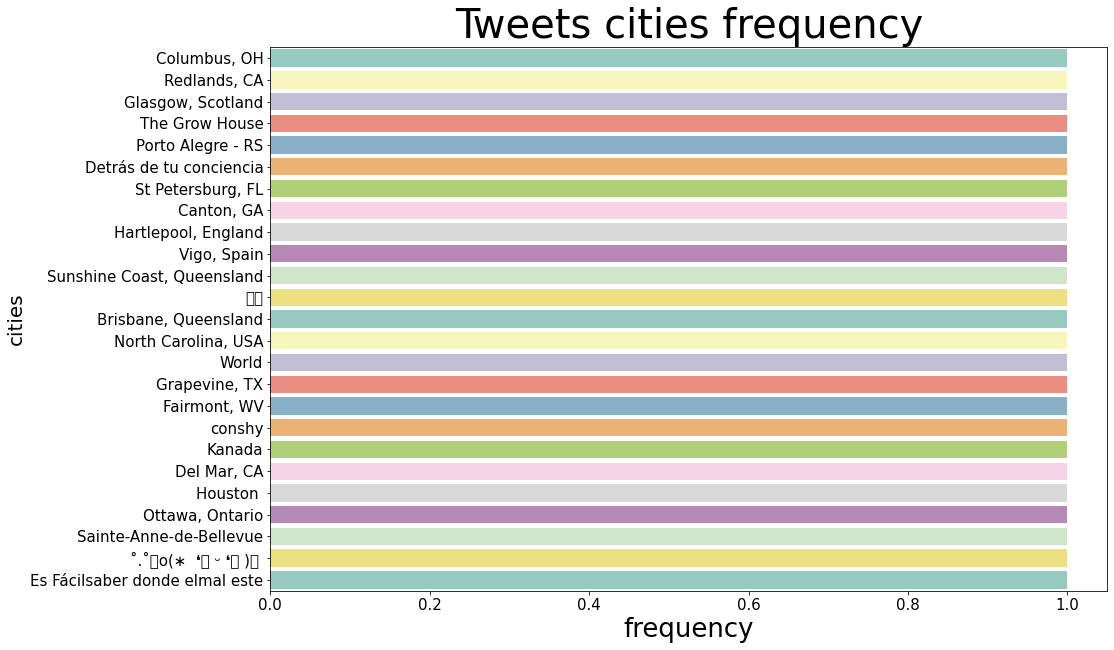

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [35]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [36]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

9


In [37]:
len(tweets_com_coordenadas)/len(results) * 100

0.8204193254329991

In [38]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'type': 'Polygon',
 'coordinates': [[[-81.877771, 41.392684],
   [-81.5331634, 41.392684],
   [-81.5331634, 41.599195],
   [-81.877771, 41.599195]]]}

In [39]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[-81.877771, 41.392684],
  [-81.5331634, 41.392684],
  [-81.5331634, 41.599195],
  [-81.877771, 41.599195]]]

In [40]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[-81.877771, 41.392684]

In [41]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [42]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[-81.877771, 41.392684],
 [-72.4223860023021, 6.04010000036506],
 [-81.507905, 28.3882177],
 [-74.964586, 38.9541601],
 [-96.286558, 29.9205075]]

In [43]:
len(tweets_com_coordenadas)

9

In [44]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [45]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

9

In [46]:
print(list(latitudes_tweets[:15]))

[41.392684, 6.04010000036506, 28.3882177, 38.9541601, 29.9205075, -31.5235762, 32.057802, 43.403221, 30.323302043297552]


In [47]:
print(list(longitudes_tweets[:15]))

[-81.877771, -72.4223860023021, -81.507905, -74.964586, -96.286558, -64.3195, -111.083219, -79.639319, -97.69093008410272]


In [48]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

,latitude,longitude
0,41.392684,-81.877771
1,6.040100,-72.422386
2,28.388218,-81.507905
3,38.954160,-74.964586
4,29.920507,-96.286558


In [ ]:
len(df10)

In [ ]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

In [ ]:
df11.to_csv('coordenadas-tweets.csv', index=False)

In [ ]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets.csv')
df11.head()

In [ ]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

In [ ]:
print(list(latitudes_tweets[:10]))

In [ ]:
print(list(longitudes_tweets[:10]))

## ler coordenadas de um arquivo

In [ ]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

In [ ]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

## remover tuplas duplicadas

In [ ]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

# Georeferenciar os tweets no mapa mundi

In [ ]:
#!pip install folium

In [49]:
tweets_coordenadasXY

[[-81.877771, 41.392684],
 [-72.4223860023021, 6.04010000036506],
 [-81.507905, 28.3882177],
 [-74.964586, 38.9541601],
 [-96.286558, 29.9205075],
 [-64.3195, -31.5235762],
 [-111.083219, 32.057802],
 [-79.639319, 43.403221],
 [-97.69093008410272, 30.323302043297552]]

In [50]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'

#png_str = write_png(mapit. .data())
#of = open('folium_map.png', 'w')
#of.write(png_str)
#of.close()

folium.Map.save(mapit, "index.html")
#import os
#cmd = 'cutycapt --url=file:///index.html --out=folium_map.png'
#os.system(cmd)

mapit

# twitter trends - assuntos mais comentados do momento

In [51]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [52]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [53]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

topicos mais comentados: Mundo 2021-09-23 19:51:51.344574
Chris Pratt
#NintendoDirect
Jack Black
カービィ
Bayonetta 3
Kirby
スプラ3
Switch
ニンダイ
Luigi
ベヨネッタ
Splatoon 3
Seth Rogen
アクトレイザー
Koeman
#DebatBFMTV
#SalarioRosa
#SecretGala2
カスタムロボ
マリオストーリー
チョコボレーシング
Brewster
Charles Martinet
#ニンテンドーダイレクト
サンブレイク
Triangle Strategy
メガドラ
バンカズ
ハトの巣
Miyamoto
Cádiz
Animal Crossing
Depay
マスター
Puigdemont
Sega Genesis
Jelani
Zemmour
Donkey Kong
Barcelona
マリオの映画
とうらぶ無双
刀剣乱舞無双
スプラトゥーン3
ヴァイオレット・エヴァーガーデン
De Jong
Memphis
Actraiser
Voice of Cards
シオカラーズ


In [54]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

topicos mais comentados: USA 2021-09-23 19:52:50.396497
Chris Pratt
Jack Black
#NintendoDirect
Luigi
Bayonetta 3
Kirby
Splatoon 3
Seth Rogen
Charles Martinet
Brewster
Jelani
Triangle Strategy
Miyamoto
Sega Genesis
#BiVisibilityDay
Actraiser
Animal Crossing
ANYA TAYLOR
Metroid Dread
Toad
CALLIE
Astral Chain
Keegan
Illumination
Chocobo GP
Kash Doll
Voice of Cards
Yoko Taro
Disco Elysium
The Roost
Collierville
Kroger
Fred Armisen
N64 GAMES
Monster Hunter
Danny Devito
Chocobo Racing
X-Men
Smash
N64 controller
Michael Key
ACNH
#WNBATopShotThis
Banjo Kazooie
Ocarina of Time
#STLFLY
Slater
KOTOR
Koeman
#ranboospace


In [55]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

In [ ]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

# Análise de Sentimentos - Tweets

In [ ]:
#!pip install textblob
#!python -m pip install --pre googletrans

In [ ]:
#!pip install googletrans
#!pip install google_trans_new

In [ ]:
#!pip install googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
translator = Translator()

#translator.translate('veritas lux mea', src='la')
translator.translate('oi, tudo bem', src='pt').text #, src='pt', dest='en') 

### Testando as polaridades

In [ ]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

In [ ]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

In [ ]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

# polaridade de tweets em ingles e portugues

In [ ]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
        if language == 'br' or language == 'pt' :
            text_en = translator.translate(text_tweet, src='pt').text  
            analysis = tb(text_en)
        elif language == 'en':   
            analysis = frase
        else:
            analysis = ""
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [ ]:
q = 'tesla'

"""
mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100
"""

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    #print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

In [ ]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

### gravando os dados do dataframe num arquivo .csv

In [ ]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [ ]:
df.loc[:, ['name', "%pos", "%neg" ]]